### Statistical description of crackling

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from brainconn.centrality import participation_coef
from brainconn.modularity import modularity_louvain_dir, modularity_louvain_und
from frites.conn.conn_tf import _create_kernel, _smooth_spectra
from frites.utils import parallel_func
from scipy.stats import ks_2samp, mannwhitneyu, ttest_1samp
from statannot import add_stat_annotation
from tqdm import tqdm
from utils import *

from config import get_dates, return_evt_dt
from GDa.loader import loader
from GDa.stats.bursting import find_activation_sequences, find_start_end
from GDa.temporal_network import temporal_network
from GDa.util import _extract_roi

#### Auxiliar functions

In [3]:
import numba as nb


@nb.jit(nopython=True)
def hamming(x, y):
    """
    Calculate the Hamming distance between two arrays.

    The Hamming distance is the number of positions at which the corresponding elements are different.

    Parameters:
    x (ndarray): first array
    y (ndarray): second array
    Returns:
    float: The Hamming distance as a proportion of the maximum possible Hamming distance.
    """
    sum_and = np.logical_and(x, y).sum()
    max_sum = np.min([x.sum(), y.sum()])
    return sum_and / max_sum


def return_consensus_vector(A, fmod=modularity_louvain_und, nruns=None):
    """
    Return the consensus vector for a given set of community assignments.

    This function takes a matrix of community assignments (A), a modularity function (fmod), and the number of runs (nruns)
    to return the consensus vector of the assignments. The consensus vector is calculated by averaging the affiliation vectors of each run.

    Parameters:
    A (ndarray or xr.DataArray): matrix of community assignments.
    fmod (callable): modularity function used to calculate community assignments. Default is louvain method.
    nruns (int): number of runs to calculate consensus vector over. Default is None.
    Returns:
    Tuple: (idx, q) where idx is the community assignments and q is the modularity score
    """
    nC = len(A)

    if isinstance(A, xr.DataArray):
        A = A.data

    # Creates consensus vector for different runs
    av = []
    for i in tqdm(range(nruns)):
        idx, _ = fmod(A, seed=i * 1000)
        av += [idx]
    av = np.stack(av)

    def _for_frame(av):
        # Allegiance for a frame
        T = np.zeros((nC, nC))
        # Affiliation vector
        # For now convert affiliation vector to igraph format
        n_comm = int(av.max() + 1)
        for j in range(n_comm):
            p_lst = np.arange(nC, dtype=int)[av == j]
            grid = np.meshgrid(p_lst, p_lst)
            grid = np.reshape(grid, (2, len(p_lst) ** 2)).T
            T[grid[:, 0], grid[:, 1]] = 1
        np.fill_diagonal(T, 0)
        return T

    T = []
    for i in range(nruns):
        T += [_for_frame(av[i])]

    T = np.stack(T).mean(0)

    return modularity_louvain_und(T)


@nb.jit(nopython=True)
def co_crackling_adj(A):
    """
    Calculate the co-crackling matrix for a given matrix adjacency.

    Parameters:
    A (ndarray): matrix of community assignments where rows are rois and columns are time points
    Returns:
    ndarray: 3-D co-crackling matrix, where the last dimension corresponds to time point.
    """
    nroi, nobs = A.shape

    out = np.zeros((nroi, nroi, nobs))

    for T in range(nobs):
        idx = A[:, T]
        out[..., T] = np.outer(idx, idx)

    return out


def plot_adj_modular(
    A, ci, offset=0.5, vmin=0, vmax=0.05, cmap="turbo", lw=5, color="k"
):
    """
    Plot a modular adjacency matrix with community boundaries.

    This function takes a adjacency matrix (A), a vector of community indices (ci), and optional arguments for
    plotting the matrix (offset, vmin, vmax, cmap, lw, color) and plots the adjacency matrix with lines denoting
    the boundaries between communities.

    Parameters:
    A (ndarray or xr.DataArray): adjacency matrix
    ci (ndarray): vector of community indices for each node in the adjacency matrix
    offset (float): offset for the community boundaries. Default is 0.5
    vmin (float): minimum value for color map. Default is 0
    vmax (float): maximum value for color map. Default is 0.05
    cmap (str): name of colormap to use. Default is 'turbo'
    lw (float): width of the lines used to draw the community boundaries. Default is 5
    color (str): color of the lines used to draw the community boundaries. Default is 'k'
    """
    _, c = np.unique(ci, return_counts=True)

    N = len(A)

    c = np.cumsum(c)
    c = np.hstack(([0], c))

    idx = np.argsort(ci)
    rois = A.sources.data[idx]

    if isinstance(A, xr.DataArray):
        plot_data = A.data[np.ix_(idx, idx)]
    else:
        plot_data = A[np.ix_(idx, idx)]
    plt.imshow(plot_data, vmin=vmin, vmax=vmax, cmap=cmap, origin="lower")
    plt.xticks(range(N), rois, rotation=90)
    plt.yticks(range(N), rois)

    for i in range(1, len(c)):
        plt.hlines(
            c[i - 1] - offset, c[i] - offset, c[i - 1] - offset, lw=lw, color=color
        )
        plt.vlines(
            c[i - 1] - offset, c[i] - offset, c[i - 1] - offset, lw=lw, color=color
        )
        plt.hlines(c[i] - offset, c[i] - offset, c[i - 1] - offset, lw=lw, color=color)
        plt.vlines(c[i] - offset, c[i] - offset, c[i - 1] - offset, lw=lw, color=color)


def create_typeI_surr(A, seed=0, n_jobs=1, verbose=False):
    """
    create_typeI_surr - function to create type I surrogate data by shuffling the timepoints across trials for each ROI

    Input:
    A (xarray.DataArray) - original data
    seed (int) - seed for random number generator, default = 0
    verbose (bool) - flag to display progress bar, default = False

    Output:
    A_surrI (xarray.DataArray) - type I surrogate data with shuffled timepoints across trials for each ROI
    """
    np.random.seed(seed)

    nrois, nfreqs, ntrials, ntimes = A.shape
    dims, coords = A.dims, A.coords

    A = A.stack(obs=("trials", "times"))

    def _loop_rois(A_np):
        # Store surrogate
        A_surrI = A_np.copy()
        # Iterator
        __iter = range(nrois)
        # Vector with trial indexes
        trials_idx = np.arange(0, ntimes * ntrials, 1, dtype=int)
        # Loop over areas
        for i in __iter:
            idx_ = np.random.choice(trials_idx, ntimes * ntrials, replace=True)
            A_surrI[i, ...] = A_np[i, idx_]

        return A_surrI

    def _for_freq(f):
        return _loop_rois(A.data[:, f, :])

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_freq, n_jobs=n_jobs, verbose=verbose, total=nfreqs
    )
    # Compute surrogate for each frequency
    A_surrI = parallel(p_fun(f) for f in range(nfreqs))
    A_surrI = np.stack(A_surrI, axis=1).reshape((nrois, nfreqs, ntrials, ntimes))
    A_surrI = xr.DataArray(A_surrI, dims=dims, coords=coords)

    return A_surrI.unstack()


def create_typeII_surr(A, seed=0, verbose=False):
    """
    create_typeII_surr - function to create type II surrogate data by shuffling the timepoints within each trial for each ROI

    Input:
    A (xarray.DataArray) - original data
    seed (int) - seed for random number generator, default = 0
    verbose (bool) - flag to display progress bar, default = False

    Output:
    A_surrII (xarray.DataArray) - type II surrogate data with shuffled timepoints within each trial for each ROI
    """
    np.random.seed(seed)

    A_surrII = A.copy()
    for i in range(nrois):
        for T in range(ntrials):
            idx_ = np.random.choice(range(ntimes), ntimes, replace=False)
            A_surrII.data[i, T, ...] = A.data[i, T, idx_]

    return A_surrII

##### Setting configurations

In [4]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [5]:
metric = "coh"
monkey = "lucy"

In [6]:
sessions = get_dates(monkey)

In [7]:
stages = [[-0.4, 0], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

In [8]:
colors = dict(
    zip(
        [
            "motor",
            "parietal",
            "prefrontal",
            "somatosensory",
            "temporal",
            "visual",
            "auditory",
        ],
        ["r", "aqua", "b", "m", "goldenrod", "green", "brown"],
    )
)

In [9]:
data_loader = loader(_ROOT=_ROOT)

#### Single session

In [10]:
kw_loader = dict(
    session="141024", aligned_at="cue", channel_numbers=False, monkey=monkey
)

In [11]:
power = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1)

In [12]:
thr = power.quantile(0.95, ("trials", "times"))

In [13]:
A = power >= thr

In [110]:
asi = create_typeI_surr(A, seed=0, verbose=True, n_jobs=1)

  0%|          |  : 0/10 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


In [111]:
# @numba.njit
def _histogram(x, bins):
    return np.histogram(x, bins=bins)[0]

In [129]:
cs = asi.sum("roi").stack(obs=("trials", "times")).data

In [156]:
counts = np.apply_along_axis(_histogram, 1, cs, bins=bins)

In [25]:
find_activation_sequences(A.sel(freqs=27).stack(obs=("trials", "times")).data[0])

array([4, 1, 1, ..., 3, 1, 5])

In [104]:
actl = [find_activation_sequences(A.sel(freqs=27).stack(obs=("trials", "times")).data[i]) for i in range(A.sizes["roi"])]

In [105]:
counts = [np.histogram(actl[i], bins=bins)[0] for i in range(len(actl))]

In [106]:
counts = np.stack(counts, 0)

In [107]:
counts = counts / counts.sum(1)[:, None]

In [108]:
counts = xr.DataArray(counts, dims=("roi", "duration"), coords=dict(roi=A.roi))

In [98]:
sns.boxplot(data=counts.to_dataframe("crk").reset_index(), x="roi", y="crk"

SyntaxError: unexpected EOF while parsing (<ipython-input-98-f35093e5aaeb>, line 1)

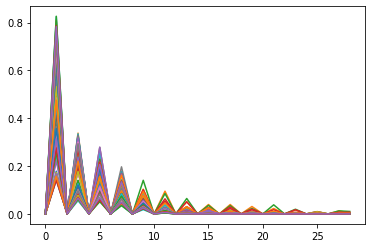

In [109]:
plt.plot(np.stack(counts, 0).T);

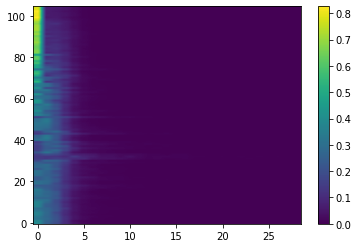

In [99]:
plt.imshow(np.stack(counts, 0), aspect="auto", origin="lower")
plt.colorbar()

In [163]:
find_activation_sequences(spike_train)

NameError: name 'spike_train' is not defined

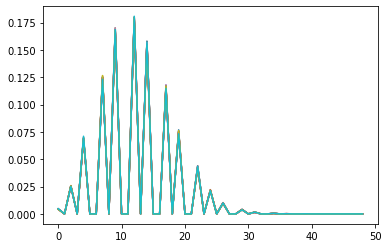

In [154]:
plt.plot(counts.T)

In [24]:
nrois, ntrials, ntimes = A.shape

In [103]:
nsurr = 100
bins = np.linspace(0, 15, 30)

In [26]:
nor = []
for i in tqdm(range(nsurr)):
    idx = np.random.choice(range(ntimes * ntrials), ntimes * ntrials, replace=True)
    nor_, _ = np.histogram(A.sum("roi").data.flatten(), bins=bins)
    nor += [nor_]
nor = np.stack(nor, axis=0)

100%|██████████| 100/100 [00:00<00:00, 130.53it/s]


In [32]:
nI = []
for i in tqdm(range(nsurr)):
    A_surrI = create_typeI_surr(A, seed=i, verbose=False)
    nI_, _ = np.histogram(A_surrI.sum("roi").data.flatten(), bins=bins)
    nI += [nI_]
nI = np.stack(nI, axis=0)

100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


In [61]:
nII = []
for i in tqdm(range(nsurr)):
    A_surrII = create_typeII_surr(A, seed=i, verbose=False)
    nII_, _ = np.histogram(A_surrII.sum("roi").data.flatten(), bins=bins)
    nII += [nII_]
nII = np.stack(nII, axis=0)

100%|██████████| 100/100 [01:55<00:00,  1.15s/it]


NameError: name 'nII' is not defined

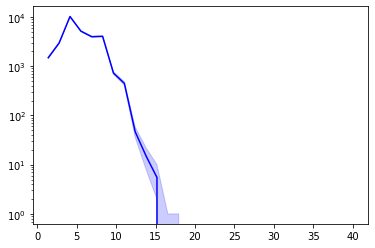

In [33]:
ax = plt.subplot(111)

plt.semilogy(bins[1:], np.quantile(nI, 0.5, 0), "b")
plt.fill_between(
    bins[1:],
    np.quantile(nI, 0.05, 0),
    np.quantile(nI, 0.95, 0),
    color="b",
    alpha=0.2,
)

plt.semilogy(bins[1:], np.quantile(nII, 0.5, 0), "g")
plt.fill_between(
    bins[1:],
    np.quantile(nII, 0.05, 0),
    np.quantile(nII, 0.95, 0),
    color="g",
    alpha=0.2,
)

[ax.spines[key].set_visible(False) for key in ["top", "right"]]

plt.xlabel("Cracle size")

In [63]:
P = []
for i in tqdm(range(30)):
    P += [(A.unstack().sum("roi") == i).mean("trials")]
P = xr.concat(P, "k")

100%|██████████| 30/30 [00:00<00:00, 248.03it/s]


In [64]:
P_surr = []
for i in tqdm(range(nsurr)):
    A_surrII = create_typeII_surr(A, seed=i, verbose=False)
    temp = []
    for k in range(30):
        temp += [(A_surrII.sum("roi") == k).mean("trials")]
    P_surr += [xr.concat(temp, "k")]
P_surr = xr.concat(P_surr, "boot")

100%|██████████| 100/100 [02:08<00:00,  1.28s/it]


In [65]:
from scipy.stats import ttest_1samp

In [66]:
t, p = ttest_1samp(P_surr, P, axis=0, alternative="greater")

In [70]:
Psig = P.copy()
Psig.values = Psig.values * (p <= 0.001)

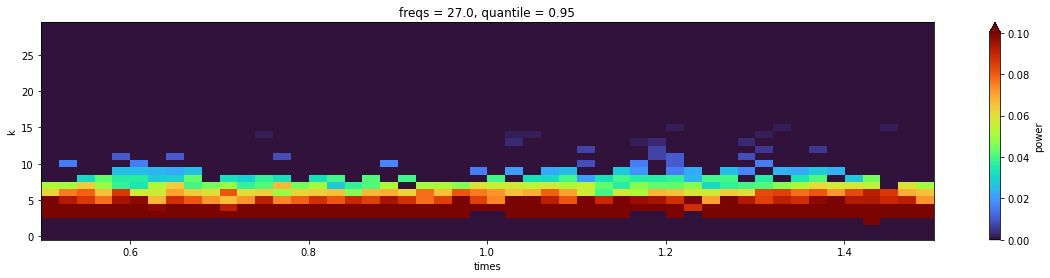

In [72]:
plt.figure(figsize=(20, 4))
Psig.sel(times=slice(-0.5, 2.5)).plot.imshow(cmap="turbo", vmin=0, vmax=0.1)